## Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
from IPython.display import Video
from ipywidgets import interact

from utils import plot_grating, plot_drift, plot_results1, plot_results2, plot_results3, \
    plot_results4, radial_mean

from functions import create_drift, apply_drift

In [2]:
# Resolution for simulations:
# Spatial resolution:
ppd = 100.  # pixels per degree

# Temporal resolution
pps = 160.  # pixels per second (Hz)

## Exploring the effect of drift eye movements
### 1. Creating a sinusoidal grating
In the first step, let's create a sinusoidal grating and some of its characteristics via the following interactive plot.
We will create the grating in 2d and 1d over 1 deg visual angle and look at it's power spectrum (2d and 1d) for a range of parameters: the spatial frequency `sf`, the phase `phi`, the contrast `C` and the spatial resolution `ppd` (=pixels per degree).
Importantly, aliasing can be found for low spatial resolution parameters and high spatial frequency parameters of the grating.

In [3]:
# Some default parameters:
# Phase of sinusoid:
phi = 0.

# Amplitude of sinusoid:
C = 1.

# Spatial extent of sinusoid:
extent = [0, 1.]

# Helper function to create oriented gratings
def create_grating(sf, alpha=0., phi=0, C=1., ppd=100., extent=[0, 1.]):
    x = np.arange(extent[0], extent[1], 1./ppd)
    xx, yy = np.meshgrid(x, x)
    alpha = [np.cos(alpha), np.sin(alpha)]

    # We use a sinusoidal grating with mean luminance of zero (= without DC component)
    grating_2d = C * np.sin((alpha[0]*xx + alpha[1]*yy) * 2. * np.pi * sf + phi)
    return grating_2d

In [4]:
# Interactively plot the grating to get to know the effect of different parameters:
def explore_grating(sf, alpha, phi, C, ppd):
    # Create sinusoidal grating:
    grating_2d = create_grating(sf, alpha=alpha, phi=phi, C=C, ppd=ppd, extent=extent)
    
    # Get 1d cut-through:
    x = np.arange(extent[0], extent[1], 1/ppd)
    nX = len(x)
    grating_1d = grating_2d[int(nX/2.), :]

    # Predefine spatial frequency axes:
    sff = np.fft.fftshift(np.fft.fftfreq(nX, d=1./ppd))

    # Calculate fft and fftshift:
    gfft_1d = np.fft.fftshift(np.fft.fft(grating_1d))
    gfft_2d = np.fft.fftshift(np.fft.fft2(grating_2d))

    # Calculate power:
    gpower_1d = np.abs(gfft_1d)**2.
    gpower_2d = np.abs(gfft_2d)**2.
    
    # Plot the grating
    plot_grating(grating_2d, gpower_2d, grating_1d, gpower_1d, extent, x, sff)

interact(explore_grating, sf=(0.,28.,7.), alpha=(-np.pi, np.pi, np.pi/4.), phi=(-np.pi,np.pi,np.pi/4.), C=(0.,2.,1.), ppd=(40.,100.,60.))

interactive(children=(FloatSlider(value=14.0, description='sf', max=28.0, step=7.0), FloatSlider(value=0.0, de…

<function __main__.explore_grating(sf, alpha, phi, C, ppd)>

### 2. Apply drift motion
We will create a small helper function that outputs both the drift trajectories as well as the full drift path (cumulative drift trajectories) for our further calculations.
The drift function takes as inputs the overall time period `T`, the sampling frequency `f_drift` and the diffusion coefficient `D` that controls the drift magnitude.

In [5]:
# Some default parameters:
# Diffusion coefficient in arcmin**2/s (controls drift magnitude)
# Kuang2012 left out the multiplication of the diffusion constant by a factor of 2 in
# the Brownian motion model. To compensate for that, we will use D=20. instead of D=40.
# as they proposed.
D = 20.

# Total time in s
# Note: if you want to sample low tfs, you need to increase T
T = 0.2

# Drift sampling frequency
# Note: if you want to sample high tfs, you need to increase f
f_drift = pps

# Helper function to create drift trajectories and paths
def drift(T=T, f_drift=f_drift, ppd=ppd, D=D, extent=extent):
    # From arcmin**2/s to deg**2/s
    D = D / (60.**2.)

    # Create drift path (continuous and in px/int):
    path_c, path = create_drift(T, f_drift, ppd, D)
    
    # Let's move the starting point of the eye motion to the grating center.
    start = extent[1] * 0.5
    path_c = path_c + start * ppd
    path = path + int(start * ppd)
    return path_c, path

To get a better idea about what drift is doing to the input, let's have a look at the following interactive plot.
In this plot, we can have a look at drift motions on our sinusoidal gratings (leftmost plot), the luminance changes over time that result from applying ocular drift (center plot) as well as the temporal power of this temporally changing signal (rightmost plot).
The four parameters that can be adapted are the spatial frequency of the grating `sf`, the diffusion coefficient that controls the drift magnitude `D`, and the number of repetitions for instantiating random drift trajectories that we use for a smoother power curve `nrep` (only relevant for the rightmost plot!).

Some interesting insights:
1. For small drift motions (small D), increasing the grating frequency increases the power at non-zero temporal frequencies. This shows that small drift motions enhance the power at high spatial frequencies.
2. For large drift motions (large D), decreasing the grating frequency mostly increases the power at non-zero temporal frequencies. This shows that there is an interaction between drift magnitude and the range of frequencies that get enhanced.
3. For high spatial frequencies (large sfs), increasing the drift magnitude decreases the overall power at non-zero temporal frequencies. This shows that high spatial frequencies get specifically enhanced by smaller drift motions.
4. If we want to sample low temporal frequencies, we need to have a sufficiently large `T`.
5. If we want to sample high temporal frequencies, we need to have a sufficiently large `f_drift`.

In [6]:
def explore_drift(sf, D, T, f_drift, nrep):
    extent = [0., 2.]

    # Predefine time and temporal frequency axis for plotting:
    nT = int(T*f_drift)+1
    t = np.linspace(0, T, nT)
    tff = np.fft.fftshift(np.fft.fftfreq(nT, d=1./f_drift))
    
    # Initiate power variable:
    gd_power = np.zeros(nT)

    # Calculate temporal power over nrep repititions:
    for i in range(nrep):
        # Create sinusoidal grating
        # Note: Since our drift motions is always applied to the center, we should
        # randomize the phase of the grating, especially for low sfs
        phi_rd = np.random.random(1) * 2 * np.pi
        grating_2d = create_grating(sf, extent=extent)

        # Create drift path:
        _, path = drift(T, f_drift, ppd, D, extent)

        # Get temporally changing signal for one pixel:
        gdrift = grating_2d[path[0,:], path[1,:]]

        # Calculate fft and fftshift:
        gd_fft = np.fft.fftshift(np.fft.fft(gdrift))

        # Calculate power:
        gd_power = (np.abs(gd_fft)**2.) / nrep + gd_power
    
    plot_drift(grating_2d, extent, path, ppd, t, gdrift, C, gd_power, tff)

interact(explore_drift, sf=(0.1,15.,4.5), D=(2.,82.,40.), T=(0.2,3.2,1.), f_drift=(50.,200.,150.), nrep=(1,50,49))

interactive(children=(FloatSlider(value=4.6, description='sf', max=15.0, min=0.1, step=4.5), FloatSlider(value…

<function __main__.explore_drift(sf, D, T, f_drift, nrep)>

## Reproducing findings
### 1. Using 1d signals
So far, we have created sinusoidal gratings and investigated how drift influences the signal over time (in the time and frequency domain) just focusing on a single pixel.
Now, we will use the same strategy to reproduce some findings in the literature.
For this, we analyse the temporally changing signal produced by drift (in the time and frequency domain) for a single pixel again - but this time, we do it systematically for a large range of gratings with different spatial frequencies.

In [7]:
# Simulating the effect of drift on the spatiotemporal power of various gratings:

# To achieve low sfs, we need a large extent
extent_ = [0., 3.]

# To achieve low tfs, we need a large T
T_ = 3.

# Drift magnitude
D_ = 20.

# Number of repititions to average across:
nrep = 30

def st_analysis_1d(ppd, extent, T, pps, D, nrep):
    nX = int((extent[1] - extent[0]) * ppd)
    nT = int(T*pps)+1
    
    # Define spatial frequencies based on spatial frequency axis.
    # We get rid of the negative frequencies and do a cut-off at maximmally 40 cpd
    sff = np.fft.fftshift(np.fft.fftfreq(nX, d=1./ppd))
    sff = sff[int(nX/2)+1::]
    sff = sff[sff<=30.]
    n_sfs = len(sff)
    
    # Initiate output variable:
    gd_power = np.zeros([nT, n_sfs])

    # Define temporal frequency axis:
    tff = np.fft.fftshift(np.fft.fftfreq(nT, d=1./pps))
    
    for j in range(nrep):
        # Initiate grating:
        grating_2d = np.zeros([nX, nX])
        
        for i in range(n_sfs):
            # Create sinusoidal grating
            phi_rd = np.random.random(1) * 2 * np.pi
            grating_2d = create_grating(sff[i], phi=phi_rd, ppd=ppd, extent=extent)

            # Create drift path:
            _, path = drift(T, pps, ppd, D, extent)

            # Get temporally changing signal for one pixel:
            gdrift = grating_2d[path[0,:], path[1,:]]

            # Calculate fft and fftshift:
            gd_fft = np.fft.fftshift(np.fft.fft(gdrift))

            # Calculate power:
            gd_power[:,i] = np.abs(gd_fft)**2. / nrep + gd_power[:,i]
            
    return gd_power, sff, tff

outputs_1d, sff_1d, tff_1d = st_analysis_1d(ppd, extent_, T_, pps, D_, nrep)

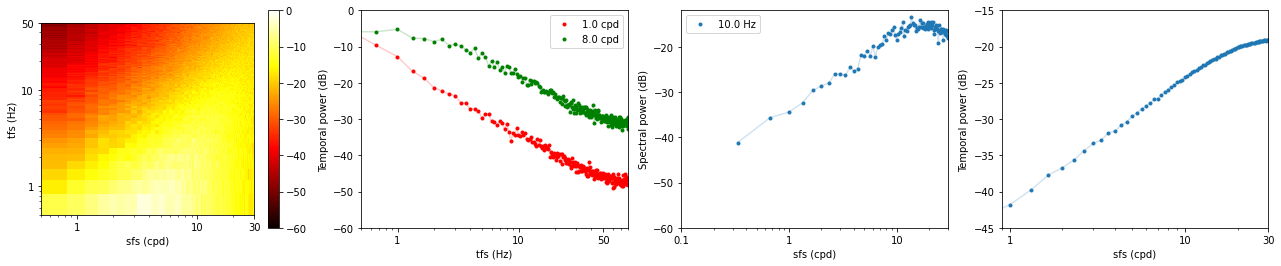

In [8]:
# Plotting results part 1: Spatiotemporal power when incorporating drift
plot_results1(outputs_1d, sff_1d, tff_1d)

![paper results](paper_results1.png "Paper results")

### 2. Using 3d signals

### 2.1 Non-natural images
So far, we have explored how we can reproduce some of the findings in the literature by focusing on simple gratings with a chosen spatial frequency that only change in the x-direction.
Above that, we only focused on the temporally changing inputs for a single pixel.
However, if we want to analyse the spatiotemporal power that results from applying drift to any kind of stimulus, we need to be able to handle signals that vary in both x- and y-direction, and we have to look at how each pixel changes over time.
For this, we will repeat the same logic but instead of using a 1d-fft, we will use a 3d-fft applied to the full image (x,y) changing over time (t).

It should be mentioned that this simulation is computationally rather demanding, since we require a high sampling frequency in both space and time to sample high spatial and temporal frequencies as well as we require a large sample in space and time to sample low spatial and temporal frequencies.

Note: Since we currently use inputs that do not change in y-direction, we are simply averaging the power spectra across the y-dimension in Fourier space.
However, this computation should rather be replaced by a radial averaging for stimuli that do change in y-direction!

In [9]:
# Simulating the effect of drift on the spatiotemporal power of various gratings:

# Since the following simulation is computationally demanding, we need to decrease
# our sampling resolution and sample sizes in space and time
# Spatial resolution
ppd_ = ppd

# Spatial extent
extent_ = [0., 3.]

# Time
T_ = 3.

# Drift magnitude
D_ = 20. * (ppd_**2.) / (60.**2.)

# Number of repititions to average across:
nrep = 10

def st_analysis_3d(ppd, extent, T, pps, D, nrep, alpha=0.):
    nX = int((extent[1] - extent[0]) * ppd)
    nT = int(T*pps)+1

    # Define spatial frequency axis
    sff = np.fft.fftshift(np.fft.fftfreq(nX, d=1./ppd))

    # We will use grating frequencies between 0 and 30 cpd
    sfs = sff[int(nX/2)+1::]
    sfs = sfs[sfs<=30.]
    n_sfs = len(sfs)

    # Define temporal frequency axis:
    tff = np.fft.fftshift(np.fft.fftfreq(nT, d=1./pps))

    # Initiate output variable:
    output_ = np.zeros([nX, nX, nT])

    for j in range(nrep):
        # Initiate grating:
        grating_2d = np.zeros([nX, nX])

        for i in range(n_sfs):
            # Create sinusoidal grating
            # In order to reduce computation time, we add up the sinusoidal gratings with
            # the different sfs
            phi_rd = np.random.random(1) * 2 * np.pi
            grating_2d = create_grating(sfs[i], alpha, phi_rd, ppd=ppd, extent=extent) + grating_2d
        
        # Create drift path:
        _, path = drift(T, pps, ppd, D, extent)

        # Apply drift to stimulus
        gvideo = apply_drift(grating_2d, path, back_lum=grating_2d.mean())

        # Calculate fft and fftshift:
        gfft_3d = np.fft.fftshift(np.fft.fftn(gvideo))
        gfft_3d = np.abs(gfft_3d)**2.
        output_ = gfft_3d / nrep + output_

    return output_, sff, tff

outputs_3d, sff_3d, tff_3d = st_analysis_3d(ppd_, extent_, T_, pps, D_, nrep)

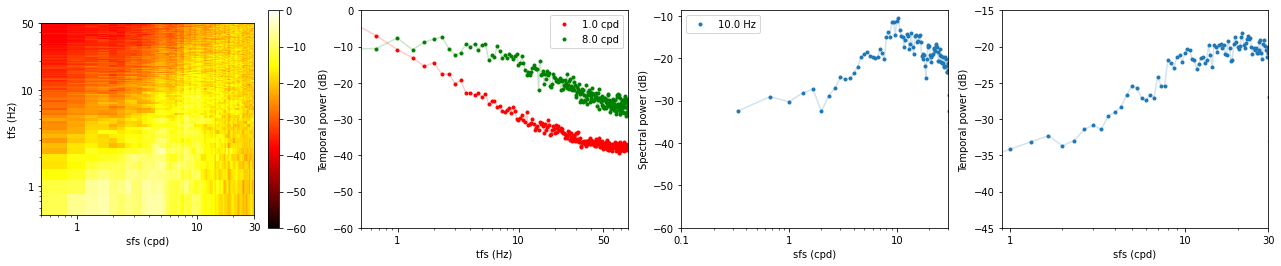

In [10]:
# Plotting results part 1: Spatiotemporal power when incorporating drift
# Cut negative sfs to make sff_3d comparable to sff_1d
sff_3d_cut = sff_3d[int(len(sff_3d)/2.+1)::]
outputs_3d_av = outputs_3d.mean(0)
outputs_3d_cut = outputs_3d_av[int(len(sff_3d)/2.+1)::, :]

# Plotting
plot_results1(np.transpose(outputs_3d_cut), sff_3d_cut, tff_3d)

![paper results](paper_results1.png "Paper results")

### 2.2 Natural images
To investigate the influence of drift motions on the spatiotemporal power of natural images, we will use the same approach as before and apply it to a natural image.
For this, we will import a natural image from the UPenn Natural image database and crop it to a size that our memory can handle (here: 300x300px or 5x5deg for ppd=60).
After making sure that the cropped section still follows typical natural image statistics (f**-1.9), we apply drift and analyse the spatiotemporal power of the drifting stimulus video as before.

In [11]:
# Import natural image and crop
sx = 300
stimulus = cv2.imread('upenn_natural_image_database_DSC_0004.JPG')
stimulus = cv2.cvtColor(stimulus, cv2.COLOR_BGR2GRAY)
stimulus = stimulus[0:sx, 0:sx]

# Define spatial frequency axis
sff = np.fft.fftshift(np.fft.fftfreq(sx, d=1./ppd))

# Define temporal frequency axis:
T = 1.5
nT = int(T*pps)+1
tff = np.fft.fftshift(np.fft.fftfreq(nT, d=1./pps))

# Perform 2d-fft to check the image statistics
fft_stim = np.fft.fftshift(np.fft.fft2(stimulus))
fft_stim = np.abs(fft_stim)**2.

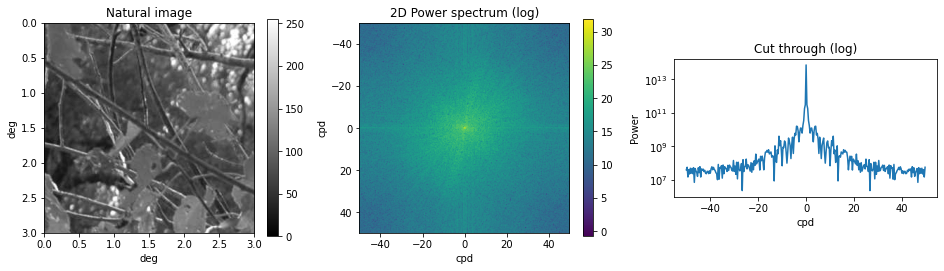

In [12]:
plt.figure(figsize=(16, 4))
plt.subplot(131, aspect=1.)
plt.imshow(stimulus, cmap='gray', extent=[0., sx/ppd, sx/ppd, 0.])
plt.ylabel('deg')
plt.xlabel('deg')
plt.title('Natural image')
plt.colorbar()

plt.subplot(132, aspect=1.)
plt.imshow(np.log(fft_stim), extent=[sff[0], sff[-1], sff[-1], sff[0]])
plt.ylabel('cpd')
plt.xlabel('cpd')
plt.title('2D Power spectrum (log)')
plt.colorbar()

plt.subplot(133, aspect=7.)
plt.plot(sff, fft_stim[int(sx/2.), :])
plt.title('Cut through (log)')
plt.ylabel('Power')
plt.xlabel('cpd')
plt.yscale('log')

In [13]:
# Initiate output variable:
output_nat = np.zeros([sx, sx, nT])
nrep = 5

for j in range(nrep):
    # Create drift path:
    _, path = drift(T, pps, ppd, D, extent)

    # Apply drift to stimulus
    gvideo = apply_drift(stimulus, path, back_lum=stimulus.mean())

    # Calculate fft and fftshift:
    gfft_3d = np.fft.fftshift(np.fft.fftn(gvideo))
    gfft_3d = np.abs(gfft_3d)**2.
    output_nat = gfft_3d / nrep + output_nat

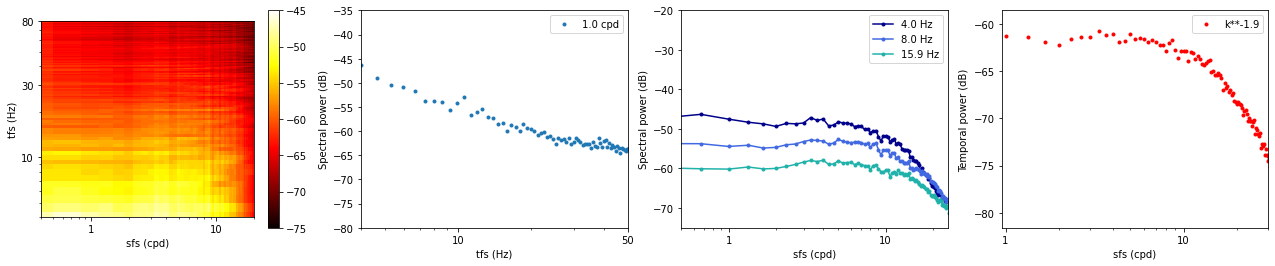

In [22]:
plot_results2(np.transpose(output_nat.mean(0)), sff, tff)

![paper_results2](paper_results2.png "Paper results")

### 3. Radial averaging

In [14]:
# To demonstrate the relevance of radial averaging, let's create the same plot
# for sinusoidal gratings rotated by 90 deg
alpha = np.pi / 2.
outputs_3d_rot, _, _ = st_analysis_3d(ppd_, extent_, T_, pps, D_, nrep, alpha)

In [15]:
# Reducing dimensionality
# Version 1: Averaging across y-dimension (as before)
outputs_3d_av = outputs_3d.mean(0)
outputs_3d_rot_av = outputs_3d_rot.mean(0)

# Version 2: Perform radial averaging
# Calculate radii to be averaged across based on sf axis:
rx, ry = np.meshgrid(sff_3d, sff_3d)
r = np.sqrt(rx**2 + ry**2)

# Perform radial averaging over the first two dims (x,y)
outputs_3d_rav, sff_rav = radial_mean(outputs_3d, r, 0.5, True)
outputs_3d_rot_rav, _ = radial_mean(outputs_3d_rot, r, 0.5, True)

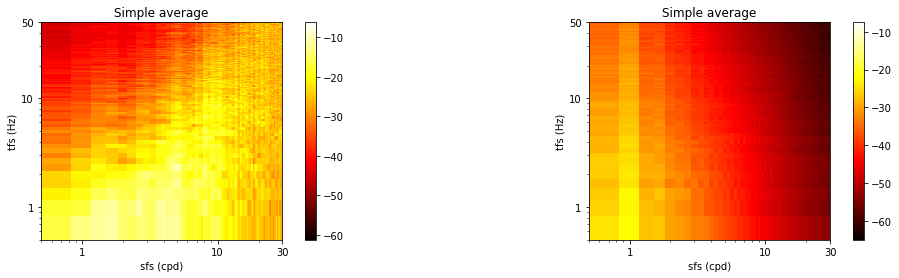

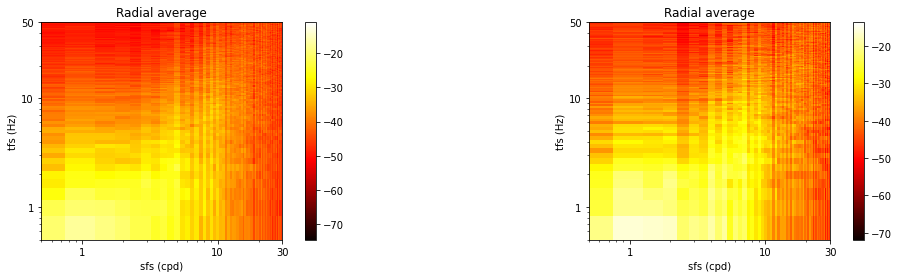

In [16]:
# Plotting results part 4: Difference simple average vs radial average
plot_results3(outputs_3d_av, outputs_3d_rot_av, sff_3d, tff_3d)
plot_results3(outputs_3d_rav, outputs_3d_rot_rav, sff_rav, tff_3d)

### 4. Applying a temporal filter
Let's have a brief look how applying a temporal filter would change the spatiotemporal power.
For this, we apply the temporal RF characteristics of a retinal M cell to the spatiotemporal power by convolving the input signal with the filter (= multiplication in Fourier space).
The temporal filter peaks at roughly 30 Hz.
After filtering the input signals, we can see that information at higher temporal frequencies is enhanced.

In [17]:
# Temporal RF of M cells adapted from Rucci code:
def M_temporal(tf):
    # parameters reported in the paper by Benardete and Kaplan
    c = .4
    A = 567
    # factor D (in ms. In the original paper it was in s)
    D = 2.2/1000.
    # if Hs = 1 then the integral of the temporal impulse response is 0
    # in the original paper Benardete and Kaplan reported Hs = .98
    # in my simulations we put Hs = 1
    Hs = 1.
    C_12 = 0.056
    T0 = 54.60
    
    # factor tau_S and tau_L (in seconds. In the original paper it was in ms)
    tau_S = (T0/(1.+(c/C_12)**2.))/1000.
    tau_L = 1.41/1000.
    N_L = 30.30
    
    # here we compute the impulse response in the Fourier domain
    w2pi = 2.*np.pi*tf
    K = A * np.exp(-1j*w2pi*D) * (1. - Hs/(1. + 1j*w2pi*tau_S)) * ((1./(1.+1j*w2pi*tau_L))**N_L)
    
    # ... and here we perform the inverse Fourier Transform
    M_T = np.fft.ifft(np.fft.ifftshift(K))
    M_T = np.real(M_T)
    return K, M_T

In [18]:
def plot_temporal_filter(T, pps):
    nT = int(T*pps)+1
    t = np.linspace(0, T, nT)
    
    # Define temporal frequency axis:
    tff = np.fft.fftshift(np.fft.fftfreq(nT, d=1./pps))
#    tff_cut = tff[int(nT/2.)::]
    
    # Create temporal filter:
    K, M_T = M_temporal(tff)
    
    plt.figure(figsize=(18, 5))
    plt.subplot(121)
    plt.plot(tff, np.abs(K), 'c.')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(0.1, 100)
    plt.xlim(0.1,100)
    plt.yticks([1, 10], [1, 10])
    plt.xticks([1, 10, 100], [1, 10, 100])
    plt.title('M cell: Temporal filter (ft)')
    plt.xlabel('tf (Hz)')
    
    plt.subplot(122)
    plt.plot(t, M_T, 'c.')
    plt.plot(t, M_T, 'c', alpha=0.3)
    plt.xlim(0, 0.15)
    plt.title('M cell: Temporal filter (time)')
    plt.xlabel('Time (ms)')
    
interact(plot_temporal_filter, T=(0.2,4.,0.4), pps=(50.,250.,50.))

interactive(children=(FloatSlider(value=1.8, description='T', max=4.0, min=0.2, step=0.4), FloatSlider(value=1…

<function __main__.plot_temporal_filter(T, pps)>

In [19]:
# Temporal RF by Watson (1986) fitted to psychophysical measures from Robson1966
def early_temporal(tf):
    tau1 = 6.22/1000.
    kappa = 1.33
    tau2 = tau1 / kappa
    n1 = 9.
    n2 = 10.
    xi = 214.
    zeta = 0.9
    
    # here we compute the impulse response in the Fourier domain
    w2pi = 2.*np.pi*tf
    H1 = (-1j*w2pi*tau1 + 1.) ** (-n1)
    H2 = (-1j*w2pi*tau2 + 1.) ** (-n2)
    H = xi * (H1 - zeta*H2)
    
    # ... and here we perform the inverse Fourier Transform
    M_T = np.fft.ifft(np.fft.ifftshift(H))
    M_T = np.real(M_T)
    return H, M_T

In [20]:
def plot_temporal_filter(T, pps):
    nT = int(T*pps)+1
    t = np.linspace(0, T, nT)
    
    # Define temporal frequency axis:
    tff = np.fft.fftshift(np.fft.fftfreq(nT, d=1./pps))
    
    # Create temporal filter:
    K, M_T = early_temporal(tff)
    
    plt.figure(figsize=(18, 5))
    plt.subplot(121)
    plt.plot(tff, np.abs(K), 'c.')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(0.1, 100)
    plt.xlim(0.1,100)
    plt.yticks([1, 10], [1, 10])
    plt.xticks([1, 10, 100], [1, 10, 100])
    plt.title('M cell: Temporal filter (ft)')
    plt.xlabel('tf (Hz)')
    
    plt.subplot(122)
    plt.plot(t, M_T, 'c.')
    plt.plot(t, M_T, 'c', alpha=0.3)
    plt.title('M cell: Temporal filter (time)')
    plt.xlabel('Time (ms)')
    
interact(plot_temporal_filter, T=(0.2,4.,0.4), pps=(50.,250.,50.))

interactive(children=(FloatSlider(value=1.8, description='T', max=4.0, min=0.2, step=0.4), FloatSlider(value=1…

<function __main__.plot_temporal_filter(T, pps)>

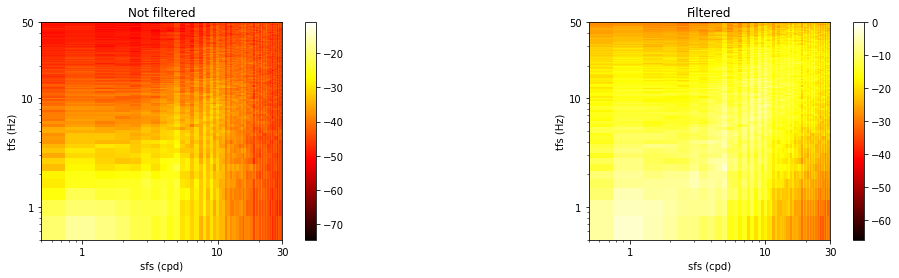

In [21]:
# Plotting results part 5: Influence of temporal filtering

# Create temporal filter:
K, _ = M_temporal(tff_3d)
K = np.abs(K)

# Filter the spatiotemporal power by multiplication with filter in Fourier space
outputs_filt = outputs_3d * np.expand_dims(K, (0,1))

# Radial averaging:
outputs_filt_rav, _ = radial_mean(outputs_filt, r, 0.5, True)

plot_results4(outputs_3d_rav, outputs_filt_rav+0.001, sff_rav, tff_3d)